# 概要
- pyroを触ってみる
  - 動作確認
- 参考
  - [Pyro document](http://pyro.ai/examples/intro_part_ii.html)
  - [Hello cybernetics](https://www.hellocybernetics.tech/entry/2020/02/17/194218)さん
  - [まるまるにっき](https://blog.snowhork.com/2018/12/introducde-pyro)さん

In [1]:
import numpy as np
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
import torch
import pyro
import pyro.infer as infer
import pyro.distributions as dist
from torch.distributions import constraints

In [3]:
seed = 100
np.random.seed(seed)
pyro.set_rng_seed(seed)

# コイントス問題（ベルヌーイ分布のパラメータ推論）
- Pyroチュートリアルにある例
- Pyroチュートリアル関係なく、確率モデルの推論における最もシンプルな例

モデル

$$
p(x, \theta) = p(x | \theta) p(\theta)
$$

ここで

$$
\begin{eqnarray}
  p(\theta) &=& \mathrm{Beta}(\theta | \alpha, \beta) \\
  p(x|\theta) &=& \mathrm{Bern}(x_n | \theta)
\end{eqnarray}
$$

## トイデータ

In [4]:
p_true = 0.6
x_sample = stats.bernoulli(p_true).rvs(50)
data = torch.tensor([float(d) for d in x_sample])
print(data)

tensor([1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1.,
        0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
        0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0.])


In [5]:
print(f'positive/total = {sum(x_sample)}:{len(x_sample)} = {sum(x_sample)/len(x_sample)}')

positive/total = 32:50 = 0.64


## モデルの構築

In [6]:
def model_coin(param=None):
    alpha0 = torch.tensor(1.0)
    beta0 = torch.tensor(1.0)
    theta = pyro.sample('theta', dist.Beta(alpha0, beta0))
    x_smp = pyro.sample('x', dist.Bernoulli(theta))
    return x_smp

cond_model = pyro.condition(
    model_coin, 
    data={'x':data})

### 構築したモデルを使ってシミュレーションができる
- 仮のパラメータを`pyro.condition`指定して、サンプルを取得

確率的にパラメータ$\theta$を決定したうえでサンプルを取得するには、HelloCyberneticsさんの[こちらの記事](https://www.hellocybernetics.tech/entry/2020/02/17/194218)にあるようにモデルの中でサンプルするパラメータを決めれば良いのかな？

In [7]:
y_sim = [pyro.sample('y', 
                     pyro.condition(model_coin, data={'theta':0.7})).item() 
         for _ in range(20)]
print(f'positive/total = {sum(y_sim)}:{len(y_sim)} = {sum(y_sim)/len(y_sim)}')
print(y_sim)

positive/total = 12.0:20 = 0.6
[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0]


## 変分推論

### 近似事後分布の形を決める

In [8]:
def posterior():
    alpha_q = pyro.param("alpha_q", torch.tensor(1.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(1.0),
                        constraint=constraints.positive)
    return dist.Beta(alpha_q, beta_q)

def guide(data):
    pyro.sample('theta', posterior())

### 推論

In [9]:
optimizer = pyro.optim.SGD({"lr": 0.001, "momentum":0.1})

svi = pyro.infer.SVI(model=cond_model, 
                     guide=guide, 
                     optim=optimizer, 
                     loss=pyro.infer.Trace_ELBO())

# do gradient steps
n_steps = 10000
for step in range(n_steps):
    svi.step(data)


### 推論結果の確認

In [10]:
for name in pyro.get_param_store():
    print("{}: {}".format(name, pyro.param(name)))

alpha_q: 30.555179595947266
beta_q: 18.06821060180664


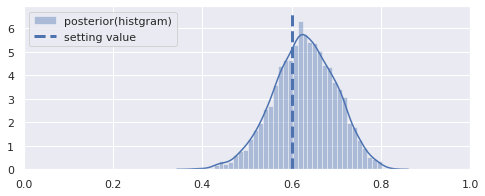

In [11]:
theta_sample_posterior = [posterior().sample() for _ in range(5000)]

fig = plt.figure(figsize=(8, 3))
ax = fig.subplots(1,1)
sns.distplot(theta_sample_posterior, ax=ax, label='posterior(histgram)')

xmin, xmax, ymin, ymax = ax.axis()
ax.vlines(p_true, ymin, ymax, linestyles='dashed', lw=3, label='setting value')

ax.set_xlim(0, 1)
ax.legend()

## MCMC

### 推論

In [12]:
nuts_kernel = infer.NUTS(cond_model, 
                         adapt_step_size=True, 
                         jit_compile=True, 
                         ignore_jit_warnings=True)
mcmc = infer.MCMC(nuts_kernel, 
                  num_samples=1500,
                  warmup_steps=500,
                  num_chains=1)

In [13]:
mcmc.run()

Sample: 100%|██████████| 2000/2000 [00:07, 263.19it/s, step size=1.27e+00, acc. prob=0.901]


### 推論結果の確認

In [14]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     theta      0.63      0.07      0.63      0.52      0.73    574.78      1.00

Number of divergences: 0


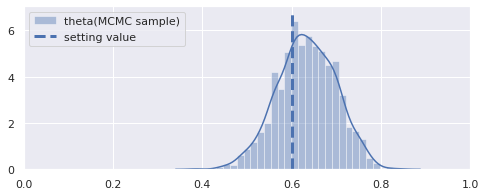

In [15]:
theta_sample_mcmc = mcmc.get_samples()['theta']

fig = plt.figure(figsize=(8, 3))
ax = fig.subplots(1,1)
sns.distplot(theta_sample_mcmc, ax=ax, label='theta(MCMC sample)')

xmin, xmax, ymin, ymax = ax.axis()
ax.vlines(p_true, ymin, ymax, linestyles='dashed', lw=3, label='setting value')

ax.set_xlim(0, 1)
ax.legend()

# ガウス分布のパラメータ推論

ガウス分布（正規分布）のパラメータを推論する

モデル

$$
p(x, \mu, \sigma) = p(x|\mu, \sigma) p(\mu) p(\sigma)
$$

ここで、

$$
\begin{eqnarray}
 p(x|\mu, \sigma) &=& \mathcal{N}(x | \mu, \sigma) \\
 p(\mu | \sigma_{\mu}) &=& \mathcal{N}(\mu | 0, \sigma_{\mu}) \\
 p(\sigma | k, \theta) &=& \mathrm{InvGamma}(\sigma | k, \theta)
\end{eqnarray}
$$

## トイデータ

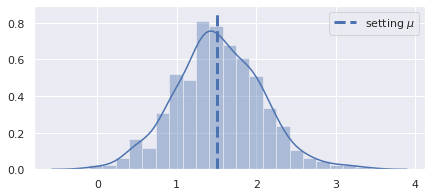

In [34]:
N = 500
mu_true = 1.5
sig_true = 0.5
xs = stats.norm(mu_true, sig_true).rvs(N)

fig = plt.figure(figsize=(7, 3))
ax = fig.subplots(1,1)
sns.distplot(xs, ax=ax)

xmin, xmax, ymin, ymax = ax.axis()
ax.vlines(mu_true, ymin, ymax, linestyles='dashed', lw=3, label='setting $\mu$')
ax.legend()

## モデル構築

In [35]:
def model_gaussian(params=None):
    mu0 = torch.tensor(0.0)
    sig0 = torch.tensor(10.0)
    mu = pyro.sample('mu', dist.Normal(mu0, sig0))
    x = pyro.sample('x', dist.Normal(mu, sig_true))
    return x

data = {'x':torch.tensor(xs)}
cond_gauss = pyro.condition(model_gaussian, 
                            data=data)

<AxesSubplot:>

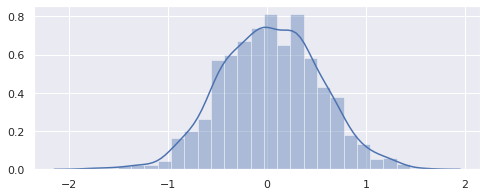

In [36]:
x_sim = [pyro.sample('x', pyro.condition(model_gaussian, data={'mu':0.0})).item() 
         for _ in range(1000)]

fig = plt.figure(figsize=(8,3))
ax = fig.subplots(1,1)
sns.distplot(x_sim, ax=ax)

## 変分推論

In [37]:
def posterior():
    mu_q = pyro.param("mu_q", torch.tensor(0.))
    sig_q = pyro.param("sig_q", torch.tensor(1.), constraint=constraints.positive)
    return dist.Normal(mu_q, sig_q)

def guide(data):
    pyro.sample('mu', posterior())


In [38]:
pyro.clear_param_store()

optimizer = pyro.optim.SGD({"lr": 0.0001, "momentum":0.1})
svi = pyro.infer.SVI(model=cond_gauss, 
                     guide=guide, 
                     optim=optimizer, 
                     loss=pyro.infer.Trace_ELBO())

# do gradient steps
n_steps = 1000
for step in range(n_steps):
    svi.step(torch.tensor(xs))


In [39]:
for name in pyro.get_param_store():
    print("{}: {}".format(name, pyro.param(name)))

mu_q: 1.5136502981185913
sig_q: 0.04887150973081589


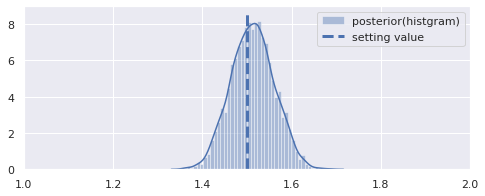

In [40]:
mu_sample_posterior = [posterior().sample() for _ in range(5000)]

fig = plt.figure(figsize=(8, 3))
ax = fig.subplots(1,1)
sns.distplot(mu_sample_posterior, ax=ax, label='posterior(histgram)')

xmin, xmax, ymin, ymax = ax.axis()
ax.vlines(mu_true, ymin, ymax, linestyles='dashed', lw=3, label='setting value')

ax.set_xlim(1, 2)
ax.legend()

## 変分推論（平均と標準偏差の推論）

In [41]:
def model_gaussian(params=None):
    mu0 = torch.tensor(0.0)
    sig0 = torch.tensor(10.0)
    a0 = torch.tensor(1.0)
    b0 = torch.tensor(2.0)
    mu = pyro.sample('mu', dist.Normal(mu0, sig0))
    sig = pyro.sample('sig', dist.InverseGamma(a0, b0))
    x = pyro.sample('x', dist.Normal(mu, sig))
    return x

data = {'x':torch.tensor(xs)}
cond_gauss = pyro.condition(model_gaussian, 
                            data=data)

事前分布から適当にサンプルを取得

<AxesSubplot:>

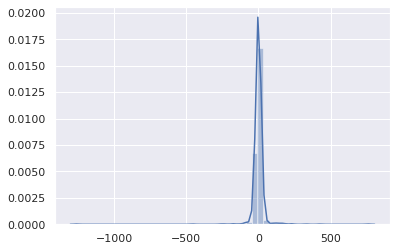

In [42]:
xs_p = [pyro.sample('xs', model_gaussian).item() for _ in range(1000)]

sns.distplot(xs_p)

これは、ガウス分布のパラメータも含めて確率モデルの事前分布としてのサンプル結果。平均や標準偏差などのパラメータは事前分布として広くとっているため、広い範囲の値がサンプルされる。

ここで、xのパラメータ（$\mu, \sigma$）を固定して（条件付けして）サンプルしてみる。
条件としてデータ（値）をモデルに入れるには、`pyro.condition`を利用する。
他にも、モデルの定義の中で、`opt`パラメータで値を入力することもできるが、入力する値に応じていちいちモデルを書き換えるのはよろしく無いので、conditionを使う。

<AxesSubplot:>

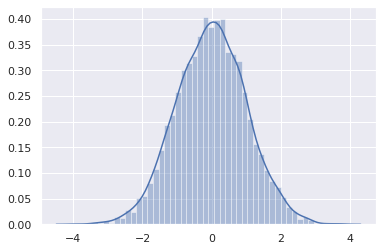

In [43]:
x_sim = [pyro.sample('x', pyro.condition(model_gaussian, 
                                         data={'mu':0.0, 
                                               'sig':1.0})).item() 
         for _ in range(5000)]

sns.distplot(x_sim)

推論の実行

In [44]:
def posterior_mu():
    mu_q = pyro.param("mu_q", torch.tensor(0.))
    sig_q = pyro.param("sig_q", torch.tensor(1.), constraint=constraints.positive)
    return dist.Normal(mu_q, sig_q)

def posterior_sig():
    a_q = pyro.param('a_q', torch.tensor(1.0), constraint=constraints.positive)
    b_q = pyro.param('b_q', torch.tensor(2.0), constraint=constraints.positive)
    return dist.InverseGamma(a_q, b_q)

def guide(data):
    pyro.sample('mu', posterior_mu())
    pyro.sample('sig', posterior_sig())


In [45]:
pyro.clear_param_store()

optimizer = pyro.optim.SGD({"lr": 0.0001, "momentum":0.1})
svi = pyro.infer.SVI(model=cond_gauss, 
                     guide=guide, 
                     optim=optimizer, 
                     loss=pyro.infer.Trace_ELBO())

# do gradient steps
n_steps = 1000
for step in range(n_steps):
    svi.step(torch.tensor(xs))


In [46]:
for name in pyro.get_param_store():
    print("{}: {}".format(name, pyro.param(name)))

mu_q: 1.5257371664047241
sig_q: 0.0573129802942276
a_q: 30.476951599121094
b_q: 16.099409103393555


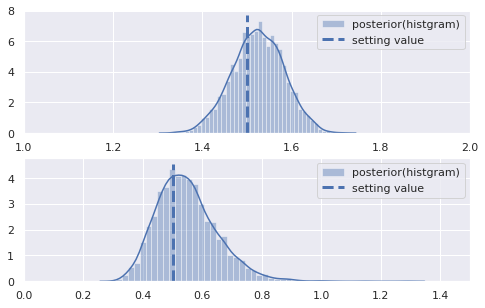

In [47]:
mu_sample_posterior = [posterior_mu().sample() for _ in range(5000)]
sig_sample_posterior = [posterior_sig().sample() for _ in range(5000)]

fig = plt.figure(figsize=(8, 5))
ax = fig.subplots(2,1)

sns.distplot(mu_sample_posterior, ax=ax[0], label='posterior(histgram)')
xmin, xmax, ymin, ymax = ax[0].axis()
ax[0].vlines(mu_true, ymin, ymax, linestyles='dashed', lw=3, label='setting value')
ax[0].set_xlim(1, 2)
ax[0].legend()

sns.distplot(sig_sample_posterior, ax=ax[1], label='posterior(histgram)')
xmin, xmax, ymin, ymax = ax[1].axis()
ax[1].vlines(sig_true, ymin, ymax, linestyles='dashed', lw=3, label='setting value')
ax[1].set_xlim(0, 1.5)
ax[1].legend()

## MCMC

In [48]:
nuts_kernel = infer.NUTS(cond_gauss, 
                         adapt_step_size=True, 
                         jit_compile=True, 
                         ignore_jit_warnings=True)
mcmc = infer.MCMC(nuts_kernel, 
                  num_samples=1500,
                  warmup_steps=500,
                  num_chains=1)

In [49]:
mcmc.run()

Sample: 100%|██████████| 2000/2000 [00:12, 155.38it/s, step size=8.30e-01, acc. prob=0.932]


In [50]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      1.52      0.02      1.52      1.48      1.56    888.76      1.00
       sig      0.54      0.02      0.54      0.51      0.57   1160.96      1.00

Number of divergences: 0


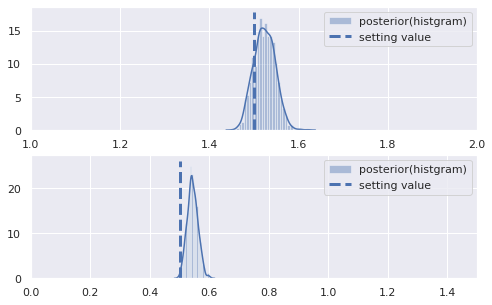

In [51]:
mu_sample_mcmc = mcmc.get_samples()['mu']
sig_sample_mcmc = mcmc.get_samples()['sig']

fig = plt.figure(figsize=(8, 5))
ax = fig.subplots(2,1)

sns.distplot(mu_sample_mcmc, ax=ax[0], label='posterior(histgram)')
xmin, xmax, ymin, ymax = ax[0].axis()
ax[0].vlines(mu_true, ymin, ymax, linestyles='dashed', lw=3, label='setting value')
ax[0].set_xlim(1, 2)
ax[0].legend()

sns.distplot(sig_sample_mcmc, ax=ax[1], label='posterior(histgram)')
xmin, xmax, ymin, ymax = ax[1].axis()
ax[1].vlines(sig_true, ymin, ymax, linestyles='dashed', lw=3, label='setting value')
ax[1].set_xlim(0, 1.5)
ax[1].legend()